In [1]:
import torch
import argparse
import random
import math
from torch.utils import data
from torchvision import datasets, transforms

from J_Model import PCModel
import J_optim as optim
import J_utils as utils

from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from copy import copy
from time import perf_counter
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd

from stimuli_data import *
from image_net_data import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

In [4]:
# ====================================================================================
#
# Global Parameters and Settings
#
# ====================================================================================
parser = argparse.ArgumentParser(description='Predictive Coding')

# dataset params
parser.add_argument('--batch-size', type=int, default=64,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')

# optim params
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--epoch', type=int, default=9, help='epochs for training') #12

# inference params
parser.add_argument('--infer-lr', type=float, default=0.005, help='Inference learning rate')
parser.add_argument('--infer-iter', type=int, default=500, help='Iteration for inference') #500
parser.add_argument('--test-iter', type=int, default=500, help='Iteration for testing') #2000
parser.add_argument('--test-infer-iter', type=int, default=20000, help='Iteration for testing') #20000
parser.add_argument('--test-lr', type=int, default=0.005, help='Iteration for testing')

# convergence tolerance
parser.add_argument('--train-convergence-norm', type=str, default="L1", help="Norm for measuring convergence")
parser.add_argument('--train-convergence-tolerance', type=float, default=1e-10, help="Tolerance for measuring convergence")
parser.add_argument('--test-convergence-norm', type=str, default="L1", help="Norm for measuring convergence")
parser.add_argument('--test-convergence-tolerance', type=float, default=1e-4, help="Tolerance for measuring convergence")

# experiment params
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--test-every', type=int, default=13, help='Test Cycle regards to Epoch ')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Gpu Setting
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Misc. Setting
# torch.manual_seed(args.seed)
torch.manual_seed(random.randint(0,1024))


In [5]:
classes = ["n11939491", "n04330267", "n04326547", "n04328186", "n04330267", "n09468604", "n09472597", "n04522168", "n02974003",
           "n03220513", "n03223299", "n03240683", "n03355925", "n03930630", "n03837869", "n03773504", "n03530642", "n02701002", 
           "n02747177", "n02727426", "n02980441"]

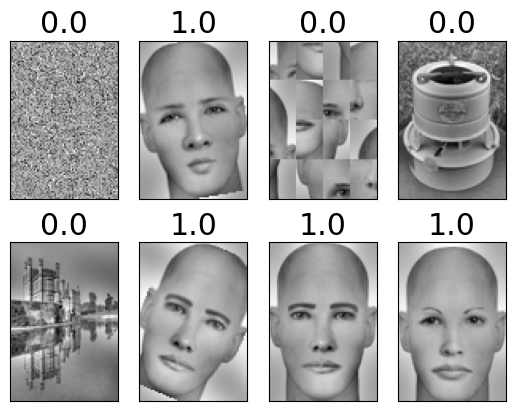

In [6]:
face_loader = get_dataloader(classes=classes, radius=(2, 3), batch_size=args.batch_size,
                            num_translations=3, num_rotations=3, num_images=123, augment_imagenet=False)

features, labels = next(iter(face_loader))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    i += 1

# Functions

In [7]:
def train_network(model, train_dl):
    optimizer = optim.get_optim(
        model.params,
        "Adam",
        args.lr,
        batch_scale=False,
        grad_clip=50)

    with torch.no_grad():
        metrics = {"acc": []}

        for epoch in range(1, args.epoch + 1):
            # Training
            #print(f"Epoch {epoch} is training with ({len(train_dl)} batches)")
            for batch_id, (img_batch, label_batch) in enumerate(train_dl):
                
                img_batch = utils.to_vector(img_batch)
                img_batch = img_batch.float().to(device)
                
                label_batch = label_batch.long()
                label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    
                model.train_batch_supervised(img_batch, label_batch, args.infer_iter, fixed_preds=False)
    
                optimizer.step(
                    curr_epoch=epoch,
                    curr_batch=batch_id,
                    n_batches=len(train_dl),
                    batch_size=img_batch.size(0),
                )
    
            # Testing
            if epoch % args.test_every == 0:
                acc = 0
                for _, (img_batch, label_batch) in enumerate(train_dl):
                    label_batch = label_batch.long()
                    img_batch = img_batch.double()
                    
                    img_batch = utils.to_vector(img_batch).to(device)
                    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    
                    label_preds, t = model.test_batch_supervised(img_batch, label_batch, args.test_iter, fixed_preds=False, 
                                                                 tol=args.train_convergence_tolerance, norm=args.train_convergence_norm)
                    #print(t)
                    acc += utils.Want_accuracy(label_preds, label_batch)
                metrics["acc"].append(acc / len(train_dl))
                print(f"\tTest epoch {epoch} with Accuracy: {acc / len(train_dl)}")

In [8]:
def test_network(model, test_dl):
    conv_times = []
    #print(conv_times)
    acc = 0 
    with torch.no_grad():
        for _, (img_batch, label_batch) in enumerate(test_dl):
            label_batch = label_batch.long()
            img_batch = img_batch.double()
            
            img_batch = utils.to_vector(img_batch).to(device)
            label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

            label_preds, times = model.test_batch_supervised(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                             tol=args.test_convergence_tolerance, norm=args.test_convergence_norm, 
                                                             mu_dt=args.test_lr)
            
            for idx in range(len(times)):
                if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
                    conv_times.append(times[idx])
                elif False: #testing plotting
                    conv_times.append(np.random.random())

            acc += utils.Want_accuracy(label_preds, label_batch)
    
    #print(sorted(conv_times))
    return conv_times, acc/len(test_dl)

In [9]:
def extract_outliers(series):
    #given a pd.Series, extract the indices of the outliers
    # outliers are points x such that:
    # x > Q3 + 1.5*IQR
    # x < Q1 - 1.5*IQR
    # IQR = Q3-Q1
    # Q1, 25th percentile
    # Q3, 75th percentile
    Q1 = series.quantile(q=0.25, interpolation='linear')
    Q3 = series.quantile(q=0.75, interpolation='linear')
    IQR = Q3 - Q1
    return series.index[(series > Q3 + 1.5*IQR) | (series < Q1 - 1.5*IQR)]

# Training Population

In [10]:
population_size = 45
networks = [PCModel(
    nodes=[2, 100, 300, 6800], #[2, 100, 300, 6800]
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh()) for i in range(population_size)]

In [11]:
#for model in networks:
#    for layer in model.layers:
#        layer.to(device)

In [ ]:
with open("training_networks_outputs.txt", "w") as file:
    file.write("") #overwrite current file
for idx, model in enumerate(networks):
    #print(f"Training the {idx+1}th network")
    
    t_start = perf_counter()
    train_network(model, face_loader)
    t_stop = perf_counter()

    with open("training_networks_outputs.txt", "a") as file: 
        file.write(f"Model {idx} done training in {round((t_stop-t_start)/60, 2)} minutes\n")
    #print("----------------------------------")
with open("training_networks_outputs.txt", "a") as file: 
    file.write("Done all training!")

In [ ]:
save_weights = True
if save_weights:
    for model_idx in range(len(networks)):
        for i in range(len(model.layers)):
            with open(f'Weights/model_{model_idx}_june_11_params_{i}.pickle', 'wb') as file:
                pickle.dump(networks[model_idx].layers[i].weights, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#population_size = 5
#networks = [PCModel(
#    nodes=[2, 100, 300, 6800], #[2, 100, 300, 6800]
#    mu_dt=args.infer_lr,
#    act_fn=utils.Tanh()) for i in range(population_size)]
#for model_idx in range(len(networks)):
#    for i in range(len(model.layers)):
#        with open(f'Weights/model_{model_idx}_june_07_params_{i}.pickle', 'rb') as file:
#            networks[model_idx].layers[i].weights = pickle.load(file)

# Testing Population

For each network in the population, we will test it on all the features, 

In [ ]:
combination_to_feature_num_dict = {
    "1 Eye": "0 Feature",
    "2 Eyes": "1 Feature",
    "1 Eye, Nose": "1 Feature",
    "1 Eye, Mouth": "1 Feature",
    "2 Eyes, Nose": "2 Feature",
    "1 Eye, Nose, Mouth": "2 Feature",
    "2 Eyes, Mouth": "2 Feature",
    "Full Face": "3 Feature"
}

In [ ]:
# set up dataframes, lists and dictionnaries to keep track of data
conv_times_for_features = {}


In [ ]:
with open("testing_networks_outputs.txt", "w") as file:
    file.write("") #overwrite current file

for feat_idx in list(range(1, 9)) + [17]: #iterate over all features
    with open("testing_networks_outputs.txt", "a") as file:
        file.write(f"Testing feature {feat_idx}:\n")
    #print(f"Testing feature {feat_idx}")
    test_dl = get_dataloader_features(feature=feat_idx, num_translations=0, num_rotations=0)

    total_times = []
    for model_idx, model in enumerate(networks):
        t_start = perf_counter()
        conv_times, acc = test_network(model, test_dl)
        t_stop = perf_counter()
        
        total_times += conv_times
        
        #print(f"\tModel {model_idx} done")
        with open("testing_networks_outputs.txt", "a") as file:
            file.write(f"\tModel {model_idx} done testing in {round((t_stop-t_start)/60, 2)} minutes\n")
    conv_times_for_features[feat_idx] = total_times 
    #conv_times_for_features[combination_to_feature_num_dict[face_features_flip_dict[feat_idx]]] = total_times
with open("testing_networks_outputs.txt", "a") as file:
    file.write("Done all testing!")

## Feature Combinations

In [26]:
df_feature_combination = pd.DataFrame()
for key in conv_times_for_features.keys()-[1]:
    df_feature_combination = pd.concat([df_feature_combination,
                                       pd.DataFrame(np.array(conv_times_for_features[key]).T, columns=[face_features_flip_dict[key]])], 
                                       axis=1)
df_feature_combination = df_feature_combination.replace([np.inf, -np.inf], np.nan)
#pd.DataFrame(np.array([conv_times_for_features[key]['times'] for key in conv_times_for_features.keys()-[1]]).T, 
#                  columns=[face_features_flip_dict[key] for key in conv_times_for_features.keys()-[1]])

In [27]:
for col in df_feature_combination.columns:
    indices = extract_outliers(df_feature_combination[col])
    print(f"{col} has {len(indices)} outliers out of {len(df_feature_combination[col][~df_feature_combination[col].isna()])} data points")

1 Eye has 132 outliers out of 2880 data points
2 Eyes has 128 outliers out of 2880 data points
1 Eye, Nose has 135 outliers out of 2880 data points
1 Eye, Mouth has 127 outliers out of 2880 data points
2 Eyes, Nose has 128 outliers out of 2880 data points
1 Eye, Nose, Mouth has 126 outliers out of 2880 data points
Full Face has 131 outliers out of 2880 data points
2 Eyes, Mouth has 139 outliers out of 2880 data points


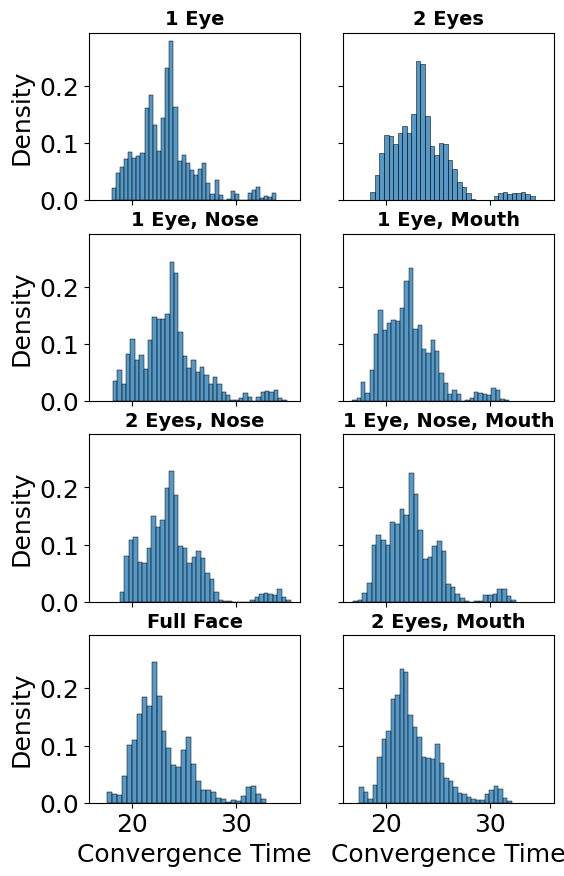

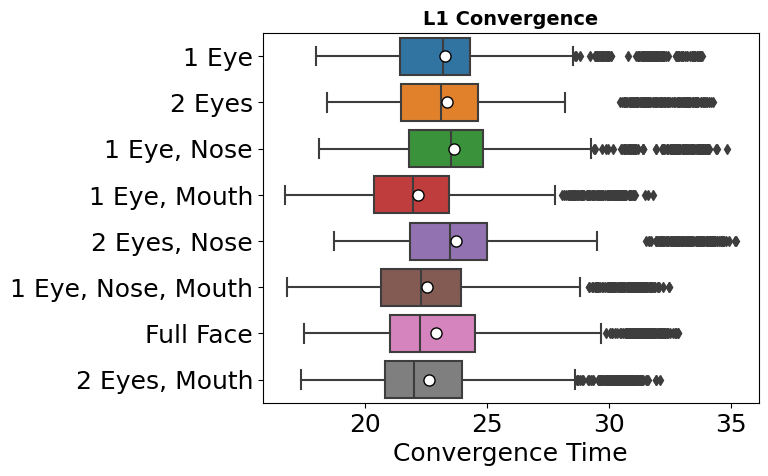

In [30]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_combination
else:
    df_subset = df_feature_combination.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(6, 10))

for i in range(len(df_subset.columns)):
    sns.histplot(df_subset, x=df_subset.columns[i], stat="density", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(df_subset.columns[i], fontsize=14, weight='bold')
    axes[i//2, i%2].set_xlabel("")
axes[-1, 0].set_xlabel("Convergence Time", fontsize=default_font_size)
axes[-1, 1].set_xlabel("Convergence Time", fontsize=default_font_size)
plt.show()

#boxplot
fig, ax = plt.subplots()
sns.boxplot(df_feature_combination, orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Convergence Time", fontsize=default_font_size)
plt.show()

In [31]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_combination
else:
    df_subset = df_feature_combination.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

for col in df_subset.columns:
    t_result = ttest_ind(df_subset["Full Face"],
                        df_subset[col],
                        equal_var=False,
                        alternative="less",
                        nan_policy="omit")
    print(f"t-test for {col} against full face response time gives \n\t{t_result.pvalue}\n")

t-test for 1 Eye against full face response time gives 
	3.8584318693997314e-06

t-test for 2 Eyes against full face response time gives 
	1.2118388522179414e-09

t-test for 1 Eye, Nose against full face response time gives 
	9.995411888989952e-21

t-test for 1 Eye, Mouth against full face response time gives 
	1.0

t-test for 2 Eyes, Nose against full face response time gives 
	6.359043045134889e-25

t-test for 1 Eye, Nose, Mouth against full face response time gives 
	0.9999999827379296

t-test for Full Face against full face response time gives 
	0.5

t-test for 2 Eyes, Mouth against full face response time gives 
	0.999986254352217



## Feature Number

In [32]:
df_feature_num = pd.DataFrame()

df_feature_num["0 Feature"] = df_feature_combination["1 Eye"]

new_df = pd.DataFrame()
new_df["1 Feature"] = pd.concat([df_feature_combination["2 Eyes"], df_feature_combination["1 Eye, Nose"], df_feature_combination["1 Eye, Mouth"]], 
                                        ignore_index=True)
df_feature_num = pd.concat([df_feature_num, new_df], axis=1)

new_df = pd.DataFrame()
new_df["2 Feature"] = pd.concat([df_feature_combination["2 Eyes, Nose"], df_feature_combination["1 Eye, Nose, Mouth"], df_feature_combination["2 Eyes, Mouth"]], 
                                        ignore_index=True)
df_feature_num = pd.concat([df_feature_num, new_df], axis=1)

new_df = pd.DataFrame()
new_df["3 Feature"] = df_feature_combination["Full Face"]
df_feature_num = pd.concat([df_feature_num, new_df], axis=1)

df_feature_num = df_feature_num.replace([np.inf, -np.inf], np.nan)
"""
temp = list(conv_times_for_features.keys())
temp.sort()

conv_times_df = pd.DataFrame()
for key in temp:
    new_df = pd.DataFrame(np.array(conv_times_for_features[key]).T, columns=[key])
    conv_times_df = pd.concat([conv_times_df, new_df], axis=1)
"""

'\ntemp = list(conv_times_for_features.keys())\ntemp.sort()\n\nconv_times_df = pd.DataFrame()\nfor key in temp:\n    new_df = pd.DataFrame(np.array(conv_times_for_features[key]).T, columns=[key])\n    conv_times_df = pd.concat([conv_times_df, new_df], axis=1)\n'

In [33]:
for col in df_feature_num.columns:
    indices = extract_outliers(df_feature_num[col])
    print(f"{col} has {len(indices)} outliers out of {len(df_feature_num[col][~df_feature_num[col].isna()])} data points")

0 Feature has 132 outliers out of 2880 data points
1 Feature has 350 outliers out of 8640 data points
2 Feature has 379 outliers out of 8640 data points
3 Feature has 131 outliers out of 2880 data points


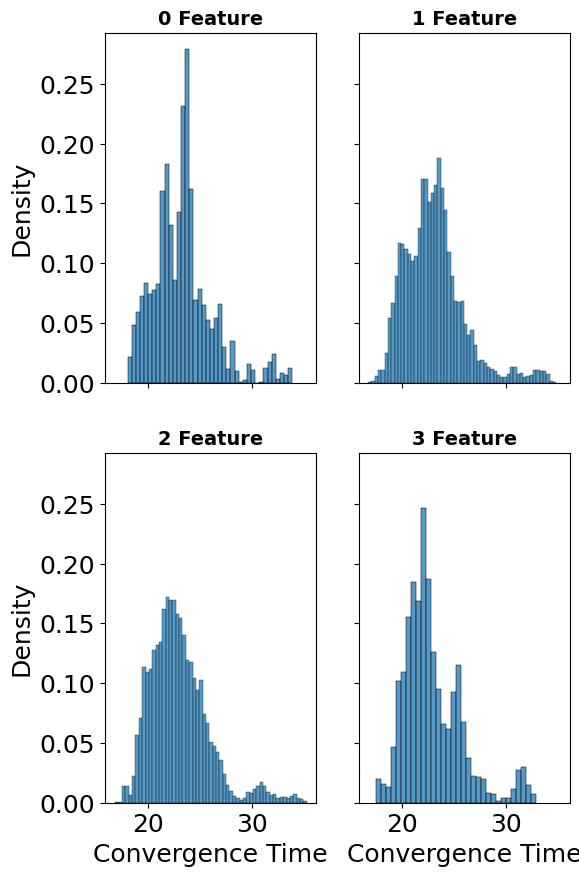

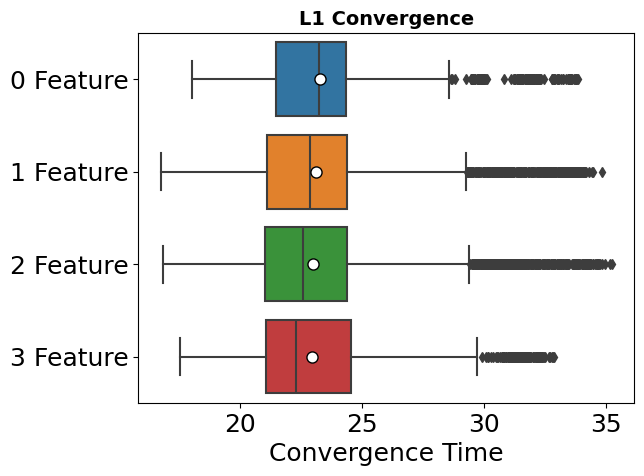

In [40]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_num
else:
    df_subset = df_feature_num.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 10))

sns.histplot(df_subset, x=df_subset.columns[0], stat="density", ax=axes[0, 0])
axes[0, 0].set_title(df_subset.columns[0], fontsize=14, weight='bold')
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[1], stat="density", ax=axes[0, 1])
axes[0, 1].set_title(df_subset.columns[1], fontsize=14, weight='bold')
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[2], stat="density", ax=axes[1, 0])
axes[1, 0].set_title(df_subset.columns[2], fontsize=14, weight='bold')
axes[1, 0].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[3], stat="density", ax=axes[1, 1])
axes[1, 1].set_title(df_subset.columns[3], fontsize=14, weight='bold')
axes[1, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

axes[-1, 0].set_xlabel("Convergence Time", fontsize=default_font_size)
axes[-1, 1].set_xlabel("Convergence Time", fontsize=default_font_size)
axes[0, 0].set_ylabel("Density", fontsize=default_font_size)
axes[1, 0].set_ylabel("Density", fontsize=default_font_size)
plt.show()

#boxplot

fig, ax = plt.subplots()
sns.boxplot(df_feature_num, orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Convergence Time", fontsize=default_font_size)
plt.show()

In [39]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_num
else:
    df_subset = df_feature_num.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

for col in df_subset.columns:
    t_result = ttest_ind(df_subset["3 Feature"],
                        df_subset[col],
                        equal_var=False,
                        alternative="less",
                        nan_policy="omit")
    print(f"t-test for {col} against full face response time gives \n\t{t_result.pvalue}\n")

t-test for 0 Feature against full face response time gives 
	3.8584318693997314e-06

t-test for 1 Feature against full face response time gives 
	0.009991021923032967

t-test for 2 Feature against full face response time gives 
	0.3330780339718005

t-test for 3 Feature against full face response time gives 
	0.5

